In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn

import sklearn
import sklearn.model_selection

rng = np.random.default_rng()

In [18]:
labels = pd.read_csv("spatial_sim_data/labels.csv", names = ["path", "N"])
print(labels.iloc[0:10,:])

                                           path    N
0  input_matrices/spatial_sim_parents_500_0.csv  531
1  input_matrices/spatial_sim_parents_500_1.csv  525
2  input_matrices/spatial_sim_parents_500_2.csv  532
3  input_matrices/spatial_sim_parents_500_3.csv  539
4  input_matrices/spatial_sim_parents_500_4.csv  528
5  input_matrices/spatial_sim_parents_500_5.csv  547
6  input_matrices/spatial_sim_parents_500_6.csv  521
7  input_matrices/spatial_sim_parents_500_7.csv  523
8  input_matrices/spatial_sim_parents_500_8.csv  543
9  input_matrices/spatial_sim_parents_500_9.csv  530


In [22]:
parents_file = "spatial_sim_data/spatial_parents/spatial_sim_parents_500_0.csv"
n = 150
parents = pd.read_csv(parents_file)
#parents.columns = ['individual', 'parent1', 'parent2', 'x', 'y', 'age']
print(parents)
N = len(parents)
sample_rows = rng.choice(np.arange(N), n, replace = False)


     individual   parent1   parent2         x         y   age
0       11519.0   10550.0   10550.0  0.897136  0.423633  88.0
1       11729.0   10829.0   10829.0  0.229187  0.078204  84.0
2       12251.0   11980.0   11980.0  0.866318  0.323394  75.0
3       12580.0   11146.0   11146.0  0.838571  0.300380  68.0
4       12632.0   12176.0   12176.0  0.264359  0.824464  67.0
..          ...       ...       ...       ...       ...   ...
526     16181.0   16052.0   16052.0  0.522768  0.772153   0.0
527     16182.0   15364.0   15364.0  0.986324  0.209085   0.0
528     16183.0   12786.0   12786.0  0.926631  0.828131   0.0
529     16185.0   15590.0   15590.0  0.023032  0.462635   0.0
530     16186.0   14721.0   14721.0  0.460829  0.660411   0.0

[531 rows x 6 columns]


In [136]:
max_rows = 50
kin_file = pd.read_csv("spatial_sim_data/input_matrices/spatial_sim_parents_500_0.csv", header = 0)
print(kin_file)
all_ages = np.array(kin_file[[' age0', ' age1']]).flatten()
print(all_ages)
max_age = np.max(all_ages)
kin_file[' age0'] = kin_file[' age0']/max_age
kin_file[' age1'] = kin_file[' age1']/max_age
kin_file = kin_file.sort_values(by = ['# parent0of1', ' parent1of0'], axis = 0, ascending = False)
kin_short = kin_file.iloc[0:max_rows, :]
kin_short = kin_short.to_numpy().reshape(1, len(kin_short), len(kin_short.columns))
input_tensor = torch.from_numpy(kin_short).float()
print(input_tensor)

       # parent0of1   parent1of0        x0        y0        x1        y1  \
0               0.0          0.0  0.926631  0.828131  0.506117  0.767903   
1               0.0          0.0  0.926631  0.828131  0.076521  0.767202   
2               0.0          0.0  0.926631  0.828131  0.260086  0.382743   
3               0.0          0.0  0.926631  0.828131  0.057782  0.517319   
4               0.0          0.0  0.926631  0.828131  0.831766  0.793029   
...             ...          ...       ...       ...       ...       ...   
11170           0.0          0.0  0.823451  0.318772  0.423007  0.208028   
11171           0.0          0.0  0.823451  0.318772  0.317089  0.822454   
11172           0.0          0.0  0.161297  0.947966  0.423007  0.208028   
11173           0.0          0.0  0.161297  0.947966  0.317089  0.822454   
11174           0.0          0.0  0.423007  0.208028  0.317089  0.822454   

        age0   age1  
0        0.0    8.0  
1        0.0    7.0  
2        0.0   17.0  

In [172]:
class KinDataset(Dataset):
    def __init__(self, base_folder, max_age, max_rows):
        self.labels = pd.read_csv(base_folder + "/labels.csv", names = ["path", "N"])
        self.base_folder = base_folder
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        kin_file = pd.read_csv(self.base_folder + "/" + self.labels.iloc[idx, 0], header = 0)
        kin_file[' age0'] = kin_file[' age0']/max_age
        kin_file[' age1'] = kin_file[' age1']/max_age
        kin_file = kin_file.sort_values(by = ['# parent0of1', ' parent1of0'], axis = 0, ascending = False)
        kin_short = kin_file.iloc[0:max_rows, :]
        kin_short = kin_short.to_numpy().reshape(1, len(kin_short), len(kin_short.columns))
        input_tensor = torch.from_numpy(kin_short).float()
        label = torch.tensor([self.labels.iloc[idx, 1]]).float()
        return input_tensor, label
    
kin_dataset = KinDataset("spatial_sim_data", 100, 50)

In [173]:
kin_dataset[0]

(tensor([[[1.0000, 0.0000, 0.2601, 0.3827, 0.2739, 0.4475, 0.2024, 0.0595],
          [1.0000, 0.0000, 0.8318, 0.7930, 0.8072, 0.7633, 0.1190, 0.0714],
          [1.0000, 0.0000, 0.5699, 0.3159, 0.5682, 0.2703, 0.1190, 0.0238],
          [1.0000, 0.0000, 0.4087, 0.3674, 0.3992, 0.3513, 0.0952, 0.0476],
          [1.0000, 0.0000, 0.7522, 0.2121, 0.7852, 0.2150, 0.3214, 0.0119],
          [1.0000, 0.0000, 0.2644, 0.8245, 0.3171, 0.8225, 0.7976, 0.1905],
          [1.0000, 0.0000, 0.3136, 0.7319, 0.3071, 0.7499, 0.0357, 0.0238],
          [1.0000, 0.0000, 0.9345, 0.7868, 0.9554, 0.8166, 0.7619, 0.4048],
          [1.0000, 0.0000, 0.9939, 0.6270, 0.0122, 0.6137, 0.0952, 0.0476],
          [0.0000, 1.0000, 0.9266, 0.8281, 0.9345, 0.7868, 0.0000, 0.7619],
          [0.0000, 1.0000, 0.2601, 0.3827, 0.2762, 0.3430, 0.2024, 0.2738],
          [0.0000, 1.0000, 0.0173, 0.1451, 0.0329, 0.1107, 0.0952, 0.1190],
          [0.0000, 1.0000, 0.2072, 0.2169, 0.2227, 0.2300, 0.0119, 0.1667],
          [0

In [174]:
n_total = len(kin_dataset)
n_train = round(n_total*0.5)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid

In [175]:
train_kin, valid_kin, test_kin = random_split(kin_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
valid_kin_dl = DataLoader(valid_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(valid_kin))
print(len(test_kin))

2500
1250
1250


In [162]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [163]:
kin_dataset[0][0].size()

torch.Size([1, 50, 8])

In [164]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      

In [165]:
x = torch.ones((4, 1, 50, 8))
model(x).shape

torch.Size([4, 64, 12, 2])

In [166]:
model.add_module('flatten', nn.Flatten()) 

In [167]:
x = torch.ones((4, 1, 50, 8))
model(x).shape

torch.Size([4, 1536])

In [168]:
model.add_module('fc1', nn.Linear(1536, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 
model.add_module('fc2', nn.Linear(1024, 1)) 

In [169]:
x = torch.ones((4, 1, 50, 8))
model(x).shape

torch.Size([4, 1])

In [170]:
model = model.to(device) 

In [ ]:
loss_fn = nn.HuberLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} loss: {loss_hist_train[epoch]:.4f} val_loss: {loss_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_kin_dl, valid_kin_dl)

Epoch 1 loss: 319.6297 val_loss: 166.9293
Epoch 2 loss: 168.7564 val_loss: 161.6267
Epoch 3 loss: 160.6901 val_loss: 157.2587
Epoch 4 loss: 157.9218 val_loss: 154.4463
Epoch 5 loss: 151.9363 val_loss: 145.5761
Epoch 6 loss: 143.6510 val_loss: 142.2059
Epoch 7 loss: 135.4022 val_loss: 121.4190
Epoch 8 loss: 122.3484 val_loss: 113.7274
Epoch 9 loss: 118.2585 val_loss: 113.8623
Epoch 10 loss: 117.3448 val_loss: 132.4307
Epoch 11 loss: 117.5433 val_loss: 110.2265
Epoch 12 loss: 116.9505 val_loss: 109.7288
Epoch 13 loss: 118.8476 val_loss: 115.3450
Epoch 14 loss: 117.6694 val_loss: 110.3691
Epoch 15 loss: 115.5387 val_loss: 129.8872
Epoch 16 loss: 121.8401 val_loss: 111.6296


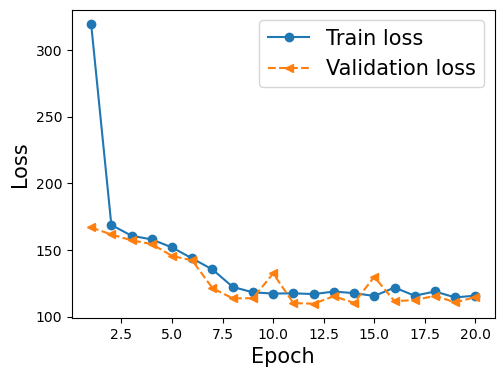

In [177]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

In [195]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))

with torch.no_grad():
    for i, (test_input, test_output) in enumerate(test_kin):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
        #test_pred[i] = test_output.numpy()
        #test_truth[i] = test_output[0].numpy()
        #test_pred[i] = model(test_input)[0, 0].numpy()

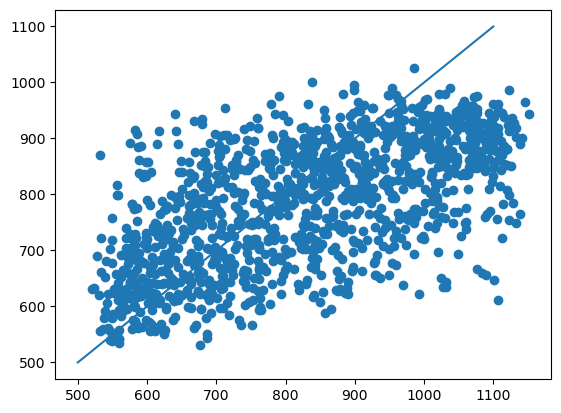

In [197]:
plt.scatter(test_truth, test_pred)
plt.plot([500, 1100], [500, 1100])